In [14]:
# %%
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

warnings.filterwarnings('ignore')
%matplotlib inline


In [15]:
# %%
import random
import numpy as np
import tensorflow as tf

SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)


In [16]:
# %%
# Load dataset
df = pd.read_csv('recruitment_data.csv')

# Define the features and the target class
x = df.drop(columns=['HiringDecision'], axis=1)
y = df['HiringDecision']

# Split the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=123)


In [17]:
# %%
# Load the saved models
model_paths = [
    'best_svm_model.pkl',
    'catBoost1model.pkl', 
    'best_knn_model.pkl',
    'LR_model_imb.pkl',
    'best_gnb_model.pkl',
    'RFmodel.pkl',
    'xgbimba.pkl',
    'DTmodel89.pkl'
]

models = []
for path in model_paths:
    model = joblib.load(path)
    if hasattr(model, 'fit'):
        models.append(model)
    else:
        print(f"Error: Loaded object from {path} is not a valid model.")

model_names = [f'model_{i+1}' for i in range(len(models))]
estimators = list(zip(model_names, models))


In [18]:
# %%
# Define possible final estimators
final_estimators = [
    LogisticRegression(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    SVC(probability=True),
    KNeighborsClassifier(),
    AdaBoostClassifier(),
    XGBClassifier(),
    GaussianNB(),
    MLPClassifier()
]


In [19]:
# %%
best_combination = None
best_final_estimator = None
best_score = 0

# Iterate over all possible combinations of models
for L in range(1, len(estimators) + 1):
    for subset in itertools.combinations(estimators, L):
        # Iterate over all final estimators
        for final_estimator in final_estimators:
            try:
                stacking_clf = StackingClassifier(
                    estimators=list(subset),
                    final_estimator=final_estimator,
                    cv=5
                )
                stacking_clf.fit(x_train, y_train)
                y_pred_test = stacking_clf.predict(x_test)
                test_accuracy = accuracy_score(y_test, y_pred_test) * 100

                if test_accuracy > best_score:
                    best_score = test_accuracy
                    best_combination = subset
                    best_final_estimator = final_estimator

                print(f"Test Accuracy with {final_estimator} and models {subset}: {test_accuracy:.2f}%")
            except Exception as e:
                print(f"Failed with {final_estimator} and models {subset}: {e}")

print(f"Best Test Accuracy: {best_score:.2f}% with {best_final_estimator} and models {best_combination}")


Test Accuracy with LogisticRegression() and models (('model_1', Pipeline(steps=[('selectkbest', SelectKBest(k=7)),
                ('svc',
                 SVC(C=0.1, gamma=1, kernel='linear', probability=True))])),): 87.33%
Test Accuracy with RandomForestClassifier() and models (('model_1', Pipeline(steps=[('selectkbest', SelectKBest(k=7)),
                ('svc',
                 SVC(C=0.1, gamma=1, kernel='linear', probability=True))])),): 80.67%
Test Accuracy with GradientBoostingClassifier() and models (('model_1', Pipeline(steps=[('selectkbest', SelectKBest(k=7)),
                ('svc',
                 SVC(C=0.1, gamma=1, kernel='linear', probability=True))])),): 87.56%
Test Accuracy with SVC(probability=True) and models (('model_1', Pipeline(steps=[('selectkbest', SelectKBest(k=7)),
                ('svc',
                 SVC(C=0.1, gamma=1, kernel='linear', probability=True))])),): 87.33%
Test Accuracy with KNeighborsClassifier() and models (('model_1', Pipeline(steps=[('sel

Accuracy:  97.33333333333334
Recall:  97.33333333333334
Precision:  97.32676923076924
F1-Score:  97.32059189195778


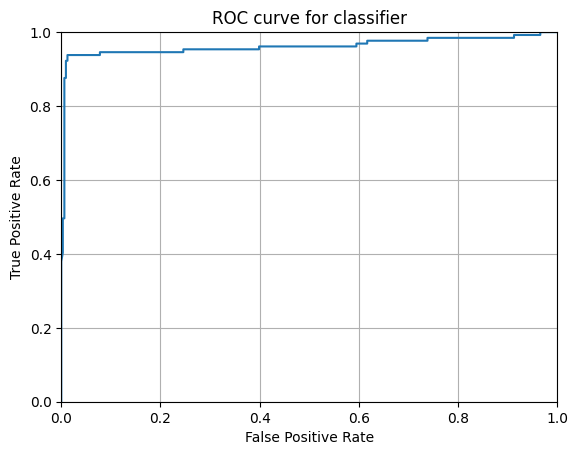

AUC Score: 0.9613972807843706
Loaded model accuracy: 97.33333333333334
StackingClassifier(cv=5,
                   estimators=[('model_2',
                                <catboost.core.CatBoostClassifier object at 0x0000012D6D94D590>),
                               ('model_5',
                                Pipeline(steps=[('selectkbest',
                                                 SelectKBest(k=6)),
                                                ('gnb',
                                                 GaussianNB(var_smoothing=5.336699231206313e-06))])),
                               ('model_8',
                                Pipeline(steps=[('smote',
                                                 SMOTE(random_state=123)),
                                                ('select_k_best',
                                                 SelectKBest(k=8)),
                                                ('classifier',
                                                 Decision

In [20]:
# %%
# Evaluate the best model
stacking_clf = StackingClassifier(
    estimators=list(best_combination),
    final_estimator=best_final_estimator,
    cv=5
)
stacking_clf.fit(x_train, y_train)
y_pred_test = stacking_clf.predict(x_test)

print('Accuracy: ', accuracy_score(y_test, y_pred_test) * 100)
print('Recall: ', recall_score(y_test, y_pred_test, average='weighted') * 100)
print('Precision: ', precision_score(y_test, y_pred_test, average='weighted') * 100)
print('F1-Score: ', f1_score(y_test, y_pred_test, average='weighted') * 100)

# Compute ROC curve and AUC score
y_pred_prob = stacking_clf.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

print("AUC Score:", roc_auc_score(y_test, y_pred_prob))

# Save the best model
joblib_file = "best_stacking_model.pkl"
joblib.dump(stacking_clf, joblib_file)

# Load and test the saved model
loaded_model = joblib.load(joblib_file)
print('Loaded model accuracy:', accuracy_score(y_test, loaded_model.predict(x_test)) * 100)
print(loaded_model)


<Figure size 800x600 with 0 Axes>

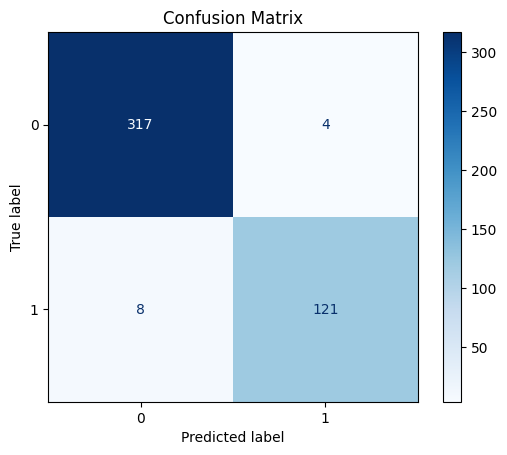

In [21]:
# %%
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=stacking_clf.classes_)
cm_display.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()
